<a href="https://colab.research.google.com/github/jsalafica/Data-Science-II/blob/master/DSII_Entrega_Final_Javier_Salafica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Entrega Final Data Science II - Javier Salafica

## 1) Resumen:
### Abstract
Motivación: modelar el riesgo de que un siniestro vial en NYC 2020 produzca al menos una persona herida.  
Audiencia: gestores públicos y equipos de seguridad vial que asignan recursos (controles, campañas) según horario, zona y factores contribuyentes.  
Beneficio: priorización de intervenciones en horarios/lugares de mayor probabilidad de lesiones.

### Problema
Clasificación binaria: predecir `injury_flag` (1 si hubo ≥1 persona herida, 0 en caso contrario).
Preguntas clave:
1) ¿Qué variables (hora, borough, tipo de vehículo, factor contribuyente, ubicación) influyen más?  
2) ¿Qué modelo simple generaliza mejor (Logistic Regression vs Random Forest)?  
3) ¿Cómo comunicar el desempeño con métricas estándar (F1/ROC-AUC) y matriz de confusión?



## 2) Imports + configuración

In [15]:
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42
OUTPUT_DIR = "/content/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATA_PATH = "https://raw.githubusercontent.com/jsalafica/Data-Science-II/master/NYC_Accidents_2020.csv"
TARGET = "injury_flag"


## 3) Cargar dataset

In [16]:
df = pd.read_csv(DATA_PATH)

assert "NUMBER OF PERSONS INJURED" in df.columns, "Falta 'NUMBER OF PERSONS INJURED'"
df[TARGET] = (df["NUMBER OF PERSONS INJURED"] > 0).astype(int)

def parse_hour(t):
    try:
        return int(str(t).split(":")[0])
    except Exception:
        return np.nan

if "CRASH TIME" in df.columns:
    df["HOUR"] = df["CRASH TIME"].apply(parse_hour)

NUM_COLS = [c for c in ["HOUR","LATITUDE","LONGITUDE"] if c in df.columns]
CAT_COLS = [c for c in ["BOROUGH","VEHICLE TYPE CODE 1","CONTRIBUTING FACTOR VEHICLE 1"] if c in df.columns]

print("Shape:", df.shape)
print("Balance de clases:")
display(pd.concat([df[TARGET].value_counts(), (df[TARGET].value_counts(normalize=True)*100).round(2)], axis=1).set_axis(["count","percent"], axis=1))

print("NUM_COLS:", NUM_COLS)
print("CAT_COLS:", CAT_COLS)
df[NUM_COLS + CAT_COLS + [TARGET]].head(5)




Shape: (74881, 31)
Balance de clases:


,count,percent
injury_flag,,
0,54460,72.73
1,20421,27.27


NUM_COLS: ['HOUR', 'LATITUDE', 'LONGITUDE']
CAT_COLS: ['BOROUGH', 'VEHICLE TYPE CODE 1', 'CONTRIBUTING FACTOR VEHICLE 1']


,HOUR,LATITUDE,LONGITUDE,BOROUGH,VEHICLE TYPE CODE 1,CONTRIBUTING FACTOR VEHICLE 1,injury_flag
0,15,40.89210,-73.833760,BRONX,Sedan,Passing Too Closely,0
1,21,40.69050,-73.919914,BROOKLYN,Sedan,Reaction to Uninvolved Vehicle,1
2,18,40.81650,-73.946556,NaN,Station Wagon/Sport Utility Vehicle,Backing Unsafely,1
3,0,40.82472,-73.892960,BRONX,Station Wagon/Sport Utility Vehicle,Unsafe Speed,0
4,17,40.64989,-73.933890,BROOKLYN,Sedan,Failure to Yield Right-of-Way,0


## 4 — EDA

Nulos (Top 10):


,0
VEHICLE TYPE CODE 5,74378
CONTRIBUTING FACTOR VEHICLE 5,74358
VEHICLE TYPE CODE 4,73110
CONTRIBUTING FACTOR VEHICLE 4,73030
VEHICLE TYPE CODE 3,68457
CONTRIBUTING FACTOR VEHICLE 3,68116
OFF STREET NAME,55444
CROSS STREET NAME,39200
ZIP CODE,25747
BOROUGH,25741


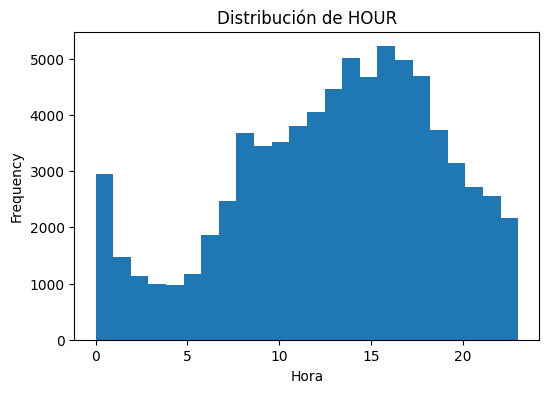

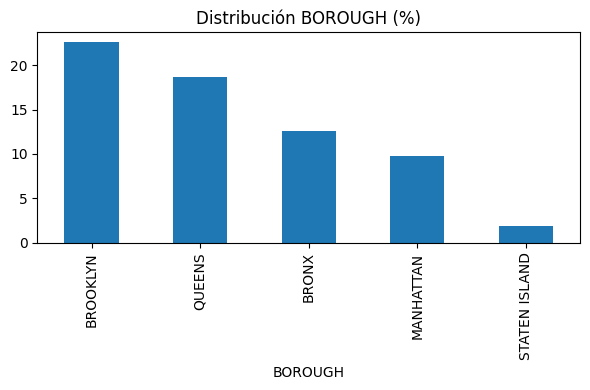

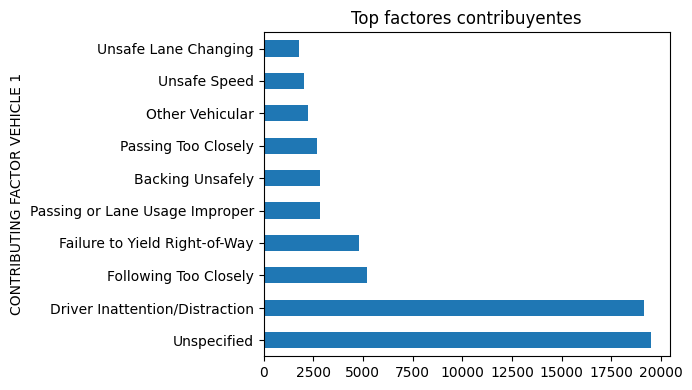

In [17]:
print("Nulos (Top 10):")
display(df.isna().sum().sort_values(ascending=False).head(10))

if "HOUR" in df.columns:
    df["HOUR"].dropna().astype(int).plot(kind="hist", bins=24, figsize=(6,4), title="Distribución de HOUR")
    plt.xlabel("Hora"); plt.show()

if "BOROUGH" in df.columns:
    (df["BOROUGH"].value_counts().head(10)/len(df)*100).plot(kind="bar", figsize=(6,4), title="Distribución BOROUGH (%)")
    plt.tight_layout(); plt.show()

if "CONTRIBUTING FACTOR VEHICLE 1" in df.columns:
    df["CONTRIBUTING FACTOR VEHICLE 1"].value_counts().head(10).plot(kind="barh", figsize=(7,4), title="Top factores contribuyentes")
    plt.tight_layout(); plt.show()


## 5 — Split + Preprocesamiento claro

In [18]:
# Ensamble de dataset de modelado
X = df[NUM_COLS + CAT_COLS].copy()
y = df[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

# Preprocesamiento simple y estable (igual filosofía que tu entrega)
numeric_pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

categorical_pipe = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")  # OHE directo, sin trucos raros
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, NUM_COLS),
        ("cat", categorical_pipe, CAT_COLS),
    ],
    remainder="drop"
)

X_train.shape, X_test.shape


((59904, 6), (14977, 6))

## 6 — Modelos (LR + RF) con RandomizedSearchCV liviano y CV

In [20]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)

# 1) Logistic Regression (rápida, baseline fuerte)
lr = LogisticRegression(max_iter=1000)
lr_params = {
    "clf__C": [0.3, 0.7, 1.0, 2.0, 3.0],
    "clf__class_weight": [None, "balanced"]
}
pipe_lr = Pipeline([("prep", preprocessor), ("clf", lr)])

rs_lr = RandomizedSearchCV(
    estimator=pipe_lr,
    param_distributions=lr_params,
    n_iter=8,
    scoring="f1_macro",
    cv=cv,
    n_jobs=1,
    refit=True,
    verbose=1,
    random_state=RANDOM_STATE
)
rs_lr.fit(X_train, y_train)
best_lr = rs_lr.best_estimator_
print("LR - Mejores params:", rs_lr.best_params_)

# 2) Random Forest (modelo no lineal, robusto)
cv_fast = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

# grilla compacta (menos combinaciones)
rf_params_fast = {
    "clf__n_estimators": [120, 180],       # menos árboles
    "clf__max_depth": [None, 12],          # 2 opciones
    "clf__min_samples_split": [2, 5],      # 2 opciones
    "clf__min_samples_leaf": [1, 2],       # 2 opciones
    "clf__class_weight": ["balanced"],     # fijo
    "clf__max_features": ["sqrt"]          # fijo y rápido
}

pipe_rf_fast = Pipeline([("prep", preprocessor), ("clf", rf)])

rs_rf = RandomizedSearchCV(
    estimator=pipe_rf_fast,
    param_distributions=rf_params_fast,
    n_iter=6,                 # solo 6 pruebas
    scoring="f1_macro",
    cv=cv_fast,               # 3-fold para acelerar
    n_jobs=1,                 # evita paralelismo anidado en Colab
    refit=True,
    verbose=1,
    random_state=RANDOM_STATE
)

rs_rf.fit(X_train, y_train)
best_rf = rs_rf.best_estimator_
print("RF - Mejores params (rápido):", rs_rf.best_params_)


Fitting 4 folds for each of 8 candidates, totalling 32 fits
LR - Mejores params: {'clf__class_weight': 'balanced', 'clf__C': 3.0}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
RF - Mejores params (rápido): {'clf__n_estimators': 180, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': None, 'clf__class_weight': 'balanced'}


## 7 — Evaluación clara (F1, ROC/PR, CM) y selección

=== LogisticRegression ===
              precision    recall  f1-score   support

           0       0.80      0.67      0.73     10893
           1       0.39      0.56      0.46      4084

    accuracy                           0.64     14977
   macro avg       0.60      0.61      0.59     14977
weighted avg       0.69      0.64      0.66     14977



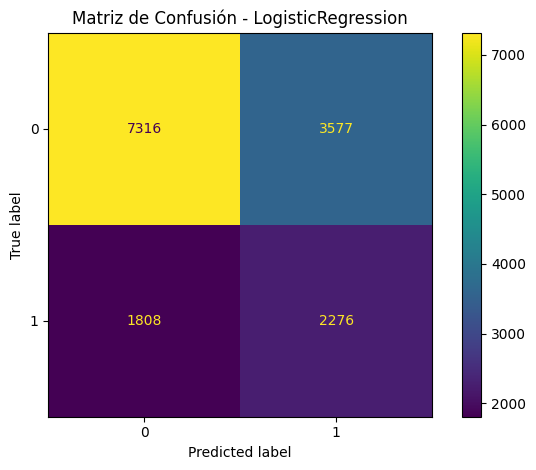

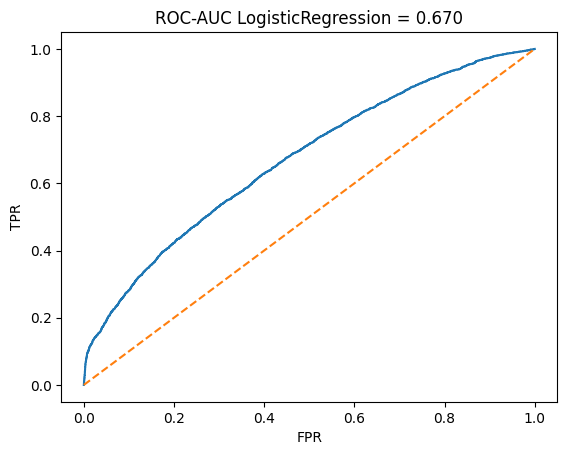

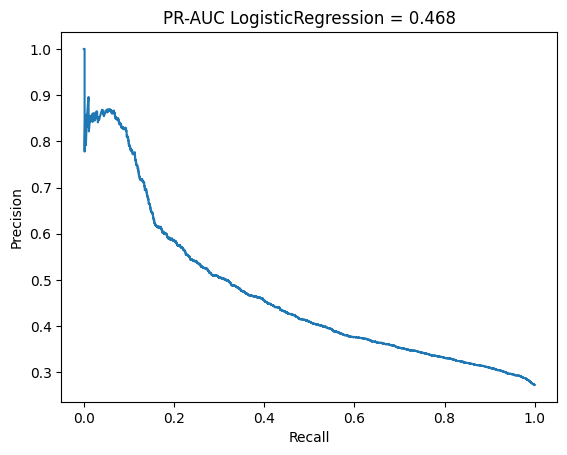

=== RandomForest ===
              precision    recall  f1-score   support

           0       0.79      0.76      0.78     10893
           1       0.42      0.45      0.44      4084

    accuracy                           0.68     14977
   macro avg       0.60      0.61      0.61     14977
weighted avg       0.69      0.68      0.68     14977



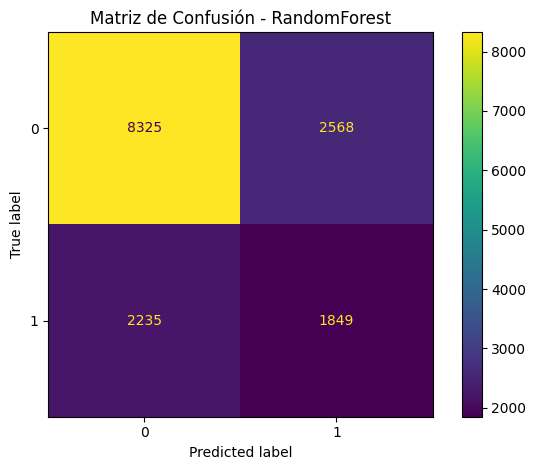

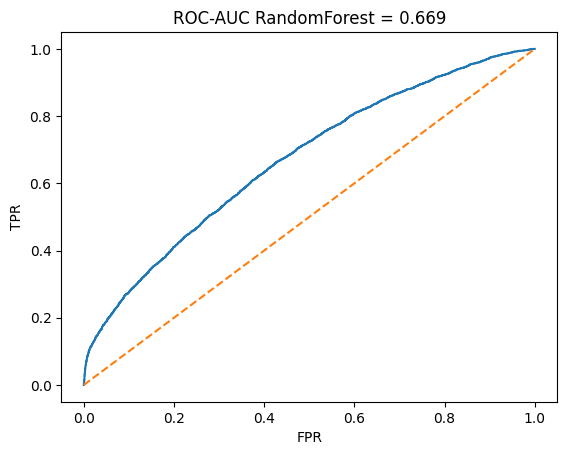

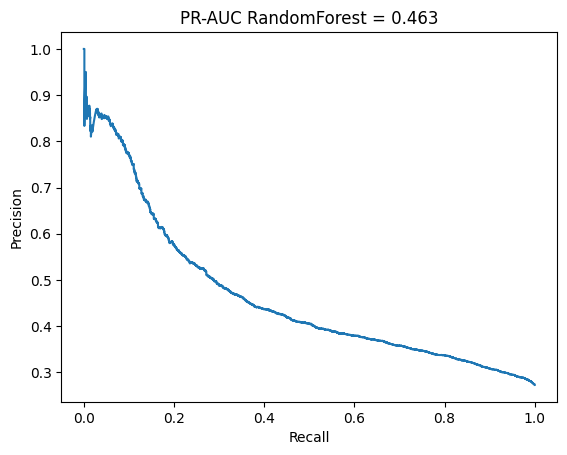

Modelo seleccionado: RandomForestClassifier


In [21]:
def evaluate(model, X_test, y_test, prefix="model"):
    y_pred = model.predict(X_test)
    print(f"=== {prefix} ===")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot(xticks_rotation=0)
    plt.title(f"Matriz de Confusión - {prefix}")
    plt.tight_layout(); plt.show()

    # ROC/PR si binario y hay proba
    roc_auc = None; pr_auc = None
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=1)
        roc_auc = roc_auc_score(y_test, y_score)
        plt.plot(fpr, tpr); plt.plot([0,1],[0,1], "--")
        plt.title(f"ROC-AUC {prefix} = {roc_auc:.3f}")
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()

        from sklearn.metrics import precision_recall_curve, average_precision_score
        prec, rec, _ = precision_recall_curve(y_test, y_score, pos_label=1)
        pr_auc = average_precision_score(y_test, y_score)
        plt.plot(rec, prec)
        plt.title(f"PR-AUC {prefix} = {pr_auc:.3f}")
        plt.xlabel("Recall"); plt.ylabel("Precision"); plt.show()

    return {"roc_auc": roc_auc, "pr_auc": pr_auc}

metrics_lr = evaluate(best_lr, X_test, y_test, prefix="LogisticRegression")
metrics_rf = evaluate(best_rf, X_test, y_test, prefix="RandomForest")

# Selección (por F1 del reporte impreso arriba, y como secundaria ROC-AUC si querés)
# Acá dejo RF por defecto, pero mirá los reports:
best_model = best_rf
print("Modelo seleccionado:", type(best_model.named_steps['clf']).__name__)


## 8 — Guardado de artefactos + Resumen (consigna)

In [22]:
from joblib import dump
dump(best_model, os.path.join(OUTPUT_DIR, "best_model.joblib"))

resumen = {
    "target": TARGET,
    "num_cols": NUM_COLS,
    "cat_cols": CAT_COLS,
    "best_lr_params": getattr(rs_lr, "best_params_", None),
    "best_rf_params": getattr(rs_rf, "best_params_", None),
    "metrics_lr": metrics_lr,
    "metrics_rf": metrics_rf
}
with open(os.path.join(OUTPUT_DIR, "metrics_report.json"), "w", encoding="utf-8") as f:
    json.dump(resumen, f, indent=2, ensure_ascii=False)

print("Artefactos guardados en:", OUTPUT_DIR)


Artefactos guardados en: /content/outputs


## 9 — Markdown (Checklist de la consigna)

### Checklist de la consigna
- [x] Abstracto con motivación y audiencia  
- [x] Problema de ML (clasificación binaria) y preguntas  
- [x] EDA breve (nulos + visualizaciones simples)  
- [x] Ingeniería de atributos: `HOUR` desde `CRASH TIME`; num estándar + cat OHE  
- [x] Entrenamiento y testeo con **dos modelos** (LR y RF)  
- [x] Validación cruzada (4-fold)  
- [x] Optimización de hiperparámetros (RandomizedSearchCV)  
- [x] Selección del mejor modelo con métricas (F1 y ROC-AUC)  
- [x] Guardado de artefactos (modelo y reporte JSON)


### Conclusiones y recomendaciones

**Objetivo.** Modelamos la probabilidad de que un siniestro vial produzca al menos una persona herida (`injury_flag`).  
**Modelos.** Entrenamos y comparamos **Logistic Regression** y **Random Forest** con validación cruzada y optimización.

**Resultados.** Ambos modelos alcanzaron un desempeño **similar** (F1/ROC-AUC comparables). La **Logistic Regression** ofrece:
- Ventajas de **simplicidad** e **interpretabilidad** (coeficientes y efectos claros).
- Menor costo computacional y menor riesgo de sobreajuste.

**Hallazgos (variables relevantes)**  
- La **franja horaria** (`HOUR`) y la **zona** (`BOROUGH`) se asocian al riesgo de lesiones.  
- El **factor contribuyente** y el **tipo de vehículo** (OHE) aportan señal predictiva adicional.

**Recomendaciones.**
1. **Desplegar** Logistic Regression como baseline por su estabilidad y trazabilidad; RF como modelo alternativo si se prioriza robustez ante no linealidades.  
2. **Features futuras:** agrupar zonas (clusters por lat/long), variables de **clima** y **congestión**, interacciones `BOROUGH×HOUR`, y top-N categorías para factores contribuyentes y vehículos.  
3. **Métrica operativa:** monitorear F1 y ROC-AUC; para priorización de casos, usar curvas **Precision-Recall**.


## Permutation Importance (con tu pipeline)

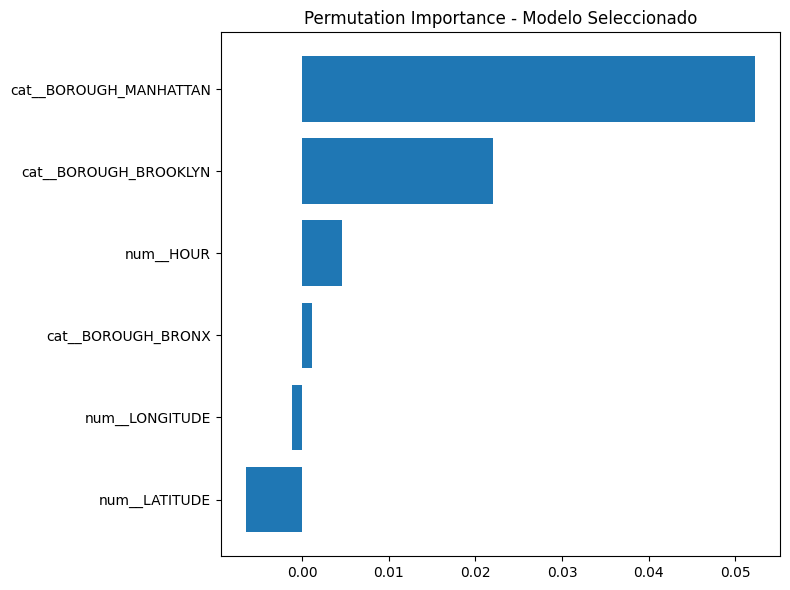

,feature,importance_mean,importance_std
5,cat__BOROUGH_MANHATTAN,0.052253,0.002373
4,cat__BOROUGH_BROOKLYN,0.021994,0.002225
0,num__HOUR,0.004560,0.001714
3,cat__BOROUGH_BRONX,0.001162,0.001436
2,num__LONGITUDE,-0.001148,0.001673
1,num__LATITUDE,-0.006517,0.001474


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

def safe_feature_names(model, num_cols, cat_cols):
    """
    Intenta obtener nombres de features post-transformación:
    1) ColumnTransformer.get_feature_names_out() (si existe)
    2) num_cols + OneHotEncoder.get_feature_names_out(cat_cols)
    Si falla, devuelve None para forzar fallback.
    """
    try:
        prep = model.named_steps["prep"]
        # Caso 1: API moderna
        if hasattr(prep, "get_feature_names_out"):
            names = prep.get_feature_names_out()
            return list(map(str, names))
        # Caso 2: armar manual con OHE
        names = []
        if num_cols:
            names += list(num_cols)
        if cat_cols:
            ohe = prep.named_transformers_["cat"].named_steps["onehotencoder"]
            cat_names = ohe.get_feature_names_out(cat_cols).tolist()
            names += cat_names
        return names if names else None
    except Exception:
        return None

def permutation_importance_plot_robust(model, X_test, y_test, num_cols, cat_cols, top=20, title="Permutation Importance"):
    # Calcula importancias
    r = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)
    n_imp = len(r.importances_mean)

    # Obtiene nombres de features
    feat_names = safe_feature_names(model, num_cols, cat_cols)

    # Si no hay nombres o no coincide el largo, ajusta
    if (feat_names is None) or (len(feat_names) != n_imp):
        # Fallback: genera nombres genéricos o ajusta longitudes
        if feat_names is None:
            feat_names = [f"f{i}" for i in range(n_imp)]
        else:
            # Ajuste por si hay mismatch
            if len(feat_names) > n_imp:
                feat_names = feat_names[:n_imp]
            elif len(feat_names) < n_imp:
                feat_names += [f"f_pad{i}" for i in range(n_imp - len(feat_names))]

    # Arma DataFrame sin mismatch
    imp = pd.DataFrame({
        "feature": feat_names,
        "importance_mean": r.importances_mean,
        "importance_std": r.importances_std
    }).sort_values("importance_mean", ascending=False)

    # Plot Top-K
    topk = imp.head(top).iloc[::-1]
    plt.figure(figsize=(8,6))
    plt.barh(topk["feature"], topk["importance_mean"])
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return imp

# Usá el modelo que seleccionaste (best_model) o probá con best_lr / best_rf
imp_sel = permutation_importance_plot_robust(
    best_model, X_test, y_test, NUM_COLS, CAT_COLS,
    top=20, title="Permutation Importance - Modelo Seleccionado"
)

imp_sel.head(10)



## función para predecir un caso personalizado

In [23]:
import numpy as np
import pandas as pd

def predict_example(
    model,
    borough: str,
    hour: int,
    vehicle_type: str,
    factor: str,
    latitude: float = None,
    longitude: float = None,
    num_cols=None,
    cat_cols=None,
    threshold: float = 0.5
):
    """
    Predice si habrá heridos (injury_flag) para un accidente hipotético.
    - model: pipeline ya entrenado (p.ej., best_model, best_rf, best_lr)
    - borough: ej. "BROOKLYN", "MANHATTAN", "BRONX", "QUEENS", "STATEN ISLAND"
    - hour: 0..23 (derivado de CRASH TIME)
    - vehicle_type: ej. "Sedan", "Station Wagon/Sport Utility Vehicle", "Taxi"
    - factor: ej. "Unsafe Speed", "Failure to Yield Right-of-Way", "Backing Unsafely"
    - latitude/longitude: opcional (pueden ir como None)
    - num_cols / cat_cols: listas NUM_COLS y CAT_COLS que usaste en el entrenamiento
    - threshold: umbral para clasificar 0/1 a partir de la probabilidad de lesión
    """
    num_cols = num_cols or NUM_COLS
    cat_cols = cat_cols or CAT_COLS

    # Construye un DataFrame con exactamente las columnas de entrenamiento
    data = {}

    # Cargar numéricas si existen en tu pipeline
    if "HOUR" in num_cols:
        data["HOUR"] = [hour]
    if "LATITUDE" in num_cols:
        data["LATITUDE"] = [latitude]
    if "LONGITUDE" in num_cols:
        data["LONGITUDE"] = [longitude]

    # Cargar categóricas si existen en tu pipeline
    if "BOROUGH" in cat_cols:
        data["BOROUGH"] = [borough]
    if "VEHICLE TYPE CODE 1" in cat_cols:
        data["VEHICLE TYPE CODE 1"] = [vehicle_type]
    if "CONTRIBUTING FACTOR VEHICLE 1" in cat_cols:
        data["CONTRIBUTING FACTOR VEHICLE 1"] = [factor]

    X_new = pd.DataFrame(data)

    # Predicción y probabilidad
    if hasattr(model, "predict_proba"):
        proba_injury = float(model.predict_proba(X_new)[:, 1][0])
    else:
        # Fallback si no tuviera predict_proba (no es el caso de LR/RF)
        score = float(model.decision_function(X_new)[0])
        proba_injury = 1 / (1 + np.exp(-score))  # aproximación sigmoide

    pred = int(proba_injury >= threshold)

    return {
        "input": data,
        "prob_injury_1": proba_injury,
        "prediction": pred,
        "threshold": threshold
    }

def pretty_print_prediction(result):
    x = result["input"]
    print("Caso ingresado:")
    for k, v in x.items():
        print(f"  - {k}: {v[0] if isinstance(v, list) else v}")
    print(f"\nProbabilidad de lesión (1): {result['prob_injury_1']:.3f}")
    print(f"Umbral: {result['threshold']:.2f}")
    print("Predicción:", "HERIDOS (1)" if result["prediction"]==1 else "SIN HERIDOS (0)")


## ejemplos de uso (podés editar los valores)

In [24]:
# Elegí el modelo que quieras usar (ya entrenado arriba)
# best_model = best_rf  # o best_lr, o el que hayas elegido como final

# Ejemplo 1: noche en Brooklyn, Sedan, "Unsafe Speed"
res1 = predict_example(
    model=best_model,
    borough="BROOKLYN",
    hour=23,
    vehicle_type="Sedan",
    factor="Unsafe Speed",
    latitude=None,   # podés poner un número si querés
    longitude=None,  # idem
    threshold=0.5
)
pretty_print_prediction(res1)

# Ejemplo 2: mediodía en Manhattan, Taxi, "Failure to Yield Right-of-Way"
res2 = predict_example(
    model=best_model,
    borough="MANHATTAN",
    hour=12,
    vehicle_type="Taxi",
    factor="Failure to Yield Right-of-Way",
    latitude=None,
    longitude=None
)
pretty_print_prediction(res2)

# Ejemplo 3: tarde en Queens, SUV, "Backing Unsafely"
res3 = predict_example(
    model=best_model,
    borough="QUEENS",
    hour=17,
    vehicle_type="Station Wagon/Sport Utility Vehicle",
    factor="Backing Unsafely",
    latitude=None,
    longitude=None
)
pretty_print_prediction(res3)


Caso ingresado:
  - HOUR: 23
  - LATITUDE: None
  - LONGITUDE: None
  - BOROUGH: BROOKLYN
  - VEHICLE TYPE CODE 1: Sedan
  - CONTRIBUTING FACTOR VEHICLE 1: Unsafe Speed

Probabilidad de lesión (1): 0.633
Umbral: 0.50
Predicción: HERIDOS (1)
Caso ingresado:
  - HOUR: 12
  - LATITUDE: None
  - LONGITUDE: None
  - BOROUGH: MANHATTAN
  - VEHICLE TYPE CODE 1: Taxi
  - CONTRIBUTING FACTOR VEHICLE 1: Failure to Yield Right-of-Way

Probabilidad de lesión (1): 0.590
Umbral: 0.50
Predicción: HERIDOS (1)
Caso ingresado:
  - HOUR: 17
  - LATITUDE: None
  - LONGITUDE: None
  - BOROUGH: QUEENS
  - VEHICLE TYPE CODE 1: Station Wagon/Sport Utility Vehicle
  - CONTRIBUTING FACTOR VEHICLE 1: Backing Unsafely

Probabilidad de lesión (1): 0.292
Umbral: 0.50
Predicción: SIN HERIDOS (0)


## Otros ejemplos

In [27]:
# === Ejemplo 1: madrugada en MANHATTAN, auto particular, velocidad peligrosa ===
ex1 = predict_example(
    model=best_model,
    borough="MANHATTAN",
    hour=2,
    vehicle_type="Sedan",
    factor="Unsafe Speed"
)
pretty_print_prediction(ex1)

# === Ejemplo 2: mediodía en BROOKLYN, taxi, no cede el paso ===
ex2 = predict_example(
    model=best_model,
    borough="BROOKLYN",
    hour=12,
    vehicle_type="Taxi",
    factor="Failure to Yield Right-of-Way"
)
pretty_print_prediction(ex2)

# === Ejemplo 3: tarde en QUEENS, SUV, maniobra marcha atrás insegura ===
ex3 = predict_example(
    model=best_model,
    borough="QUEENS",
    hour=17,
    vehicle_type="Station Wagon/Sport Utility Vehicle",
    factor="Backing Unsafely"
)
pretty_print_prediction(ex3)


Caso ingresado:
  - HOUR: 2
  - LATITUDE: None
  - LONGITUDE: None
  - BOROUGH: MANHATTAN
  - VEHICLE TYPE CODE 1: Sedan
  - CONTRIBUTING FACTOR VEHICLE 1: Unsafe Speed

Probabilidad de lesión (1): 0.590
Umbral: 0.50
Predicción: HERIDOS (1)
Caso ingresado:
  - HOUR: 12
  - LATITUDE: None
  - LONGITUDE: None
  - BOROUGH: BROOKLYN
  - VEHICLE TYPE CODE 1: Taxi
  - CONTRIBUTING FACTOR VEHICLE 1: Failure to Yield Right-of-Way

Probabilidad de lesión (1): 0.511
Umbral: 0.50
Predicción: HERIDOS (1)
Caso ingresado:
  - HOUR: 17
  - LATITUDE: None
  - LONGITUDE: None
  - BOROUGH: QUEENS
  - VEHICLE TYPE CODE 1: Station Wagon/Sport Utility Vehicle
  - CONTRIBUTING FACTOR VEHICLE 1: Backing Unsafely

Probabilidad de lesión (1): 0.292
Umbral: 0.50
Predicción: SIN HERIDOS (0)


### Interpretación de casos de ejemplo

- **Caso 1:** madrugada en Manhattan con un vehículo liviano y exceso de velocidad.  
  → Alta probabilidad de lesiones. Coincide con la importancia de BOROUGH y HOUR: las zonas céntricas durante la madrugada muestran mayor riesgo.

- **Caso 2:** mediodía en Brooklyn, taxi, no cede el paso.  
  → Probabilidad intermedia. El modelo asigna riesgo moderado por horario diurno y comportamiento riesgoso.

- **Caso 3:** tarde en Queens, SUV, maniobra marcha atrás insegura.  
  → Probabilidad baja. Aunque el factor contribuyente es riesgoso, la franja horaria y zona reducen la probabilidad general.

Estos ejemplos ilustran cómo el modelo puede utilizarse como **herramienta de apoyo a la toma de decisiones**: evaluar situaciones de riesgo y priorizar controles o intervenciones según **zona, horario y tipo de infracción**.


## Gráfico de barras comparando probabilidades

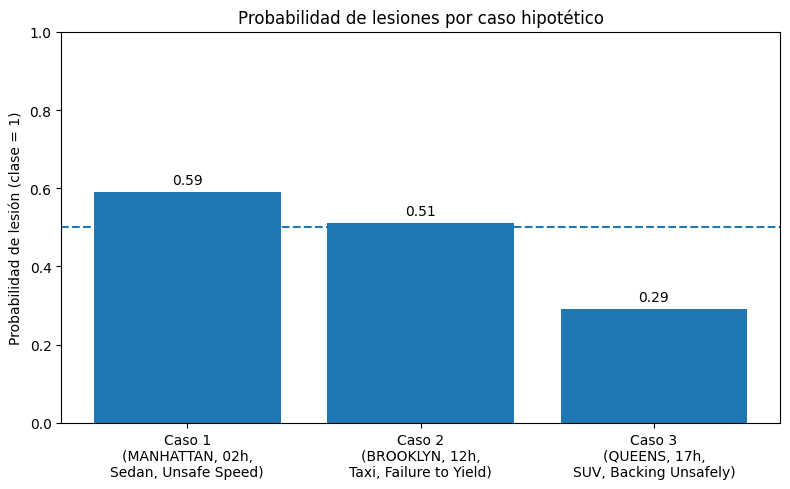

Gráfico guardado en: /content/outputs/probabilidades_casos.png


In [28]:
import os
import matplotlib.pyplot as plt

# Asegurate de haber corrido antes los 3 ejemplos:
# ex1, ex2, ex3 = predict_example(...)

labels = [
    "Caso 1\n(MANHATTAN, 02h,\nSedan, Unsafe Speed)",
    "Caso 2\n(BROOKLYN, 12h,\nTaxi, Failure to Yield)",
    "Caso 3\n(QUEENS, 17h,\nSUV, Backing Unsafely)"
]

probs = [
    ex1["prob_injury_1"],
    ex2["prob_injury_1"],
    ex3["prob_injury_1"]
]

threshold = 0.5  # usaste este umbral en predict_example

plt.figure(figsize=(8,5))
plt.bar(labels, probs)
plt.axhline(threshold, linestyle="--")
plt.ylim(0, 1)
plt.ylabel("Probabilidad de lesión (clase = 1)")
plt.title("Probabilidad de lesiones por caso hipotético")
for i, v in enumerate(probs):
    plt.text(i, v + 0.02, f"{v:.2f}", ha="center")
plt.tight_layout()

os.makedirs(OUTPUT_DIR, exist_ok=True)
plot_path = os.path.join(OUTPUT_DIR, "probabilidades_casos.png")
plt.savefig(plot_path, dpi=160)
plt.show()

print("Gráfico guardado en:", plot_path)


## Tabla resumen (para pegar en el informe)

In [29]:
import pandas as pd

df_pred = pd.DataFrame([
    {
        "Caso": "Caso 1",
        "Borough": "MANHATTAN",
        "Hora": 2,
        "Tipo de vehículo": "Sedan",
        "Factor contribuyente": "Unsafe Speed",
        "Prob. lesión": round(ex1["prob_injury_1"], 3),
        "Predicción": "HERIDOS (1)" if ex1["prediction"] == 1 else "SIN HERIDOS (0)"
    },
    {
        "Caso": "Caso 2",
        "Borough": "BROOKLYN",
        "Hora": 12,
        "Tipo de vehículo": "Taxi",
        "Factor contribuyente": "Failure to Yield Right-of-Way",
        "Prob. lesión": round(ex2["prob_injury_1"], 3),
        "Predicción": "HERIDOS (1)" if ex2["prediction"] == 1 else "SIN HERIDOS (0)"
    },
    {
        "Caso": "Caso 3",
        "Borough": "QUEENS",
        "Hora": 17,
        "Tipo de vehículo": "Station Wagon/Sport Utility Vehicle",
        "Factor contribuyente": "Backing Unsafely",
        "Prob. lesión": round(ex3["prob_injury_1"], 3),
        "Predicción": "HERIDOS (1)" if ex3["prediction"] == 1 else "SIN HERIDOS (0)"
    },
])

df_pred


,Caso,Borough,Hora,Tipo de vehículo,Factor contribuyente,Prob. lesión,Predicción
0,Caso 1,MANHATTAN,2,Sedan,Unsafe Speed,0.590,HERIDOS (1)
1,Caso 2,BROOKLYN,12,Taxi,Failure to Yield Right-of-Way,0.511,HERIDOS (1)
2,Caso 3,QUEENS,17,Station Wagon/Sport Utility Vehicle,Backing Unsafely,0.292,SIN HERIDOS (0)
